In [1]:
# Implementation of ant colony optimization algorithm

# importing necessary libraries

import jax
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 1200

import random
np.random.seed(69)
random.seed(69)


2023-01-26 12:02:45.027918: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-26 12:02:45.143793: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-26 12:02:45.144540: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


# Truss

In [2]:
# defining the geometery of truss

E = 1e7 #68947572.93178 # KN/m^2 (10e7 psi) modulus_of_elasticity
p = 0.1  #27.1447138 # KN/m^3 (0.1 lb/in^3) weight_density
s_lim = 25000 #172368.93233 #KN/m^2 (25000 psi) # allowable_stress_compression = 172368.93233 #KN/m^2 (25000 psi)
d_lim =  2 #0.0508 #m (2 inch) #displacemnt limit

In [3]:
area_avalival = [1.62, 1.80,2.38, 2.62, 2.88, 3.09, 3.13,
3.38,3.63,3.84,3.87,4.18,4.49,4.80,4.97,5.12, 5.74, 7.22,
7.97,11.5,13.5,13.9,14.2,15.5,16.0,18.8,19.9,22.0,22.9,
26.5, 30.0, 33.5]  ## sq inch

In [4]:
nodes, bars =[], []

nodes.append([100,460]) #node0
nodes.append([460,460]) #node1
nodes.append([820,460]) #node2
nodes.append([100,100]) #node3
nodes.append([460,100]) #node4
nodes.append([820,100]) #node5

bars.append([0,1]) #bar1  #dont forget python starts with 0
bars.append([1,2]) #bar2

bars.append([3,4]) #bar3
bars.append([4,5]) #bar4


bars.append([1,4]) #bar5
bars.append([2,5]) #bar6

bars.append([0,4]) #bar7
bars.append([1,3]) #bar8

bars.append([1,5]) #bar9
bars.append([2,4]) #bar10

nodes = np.array(nodes).astype(float)
bars = np.array(bars)
original_nodes = np.copy(nodes)

In [5]:
bars

array([[0, 1],
       [1, 2],
       [3, 4],
       [4, 5],
       [1, 4],
       [2, 5],
       [0, 4],
       [1, 3],
       [1, 5],
       [2, 4]])

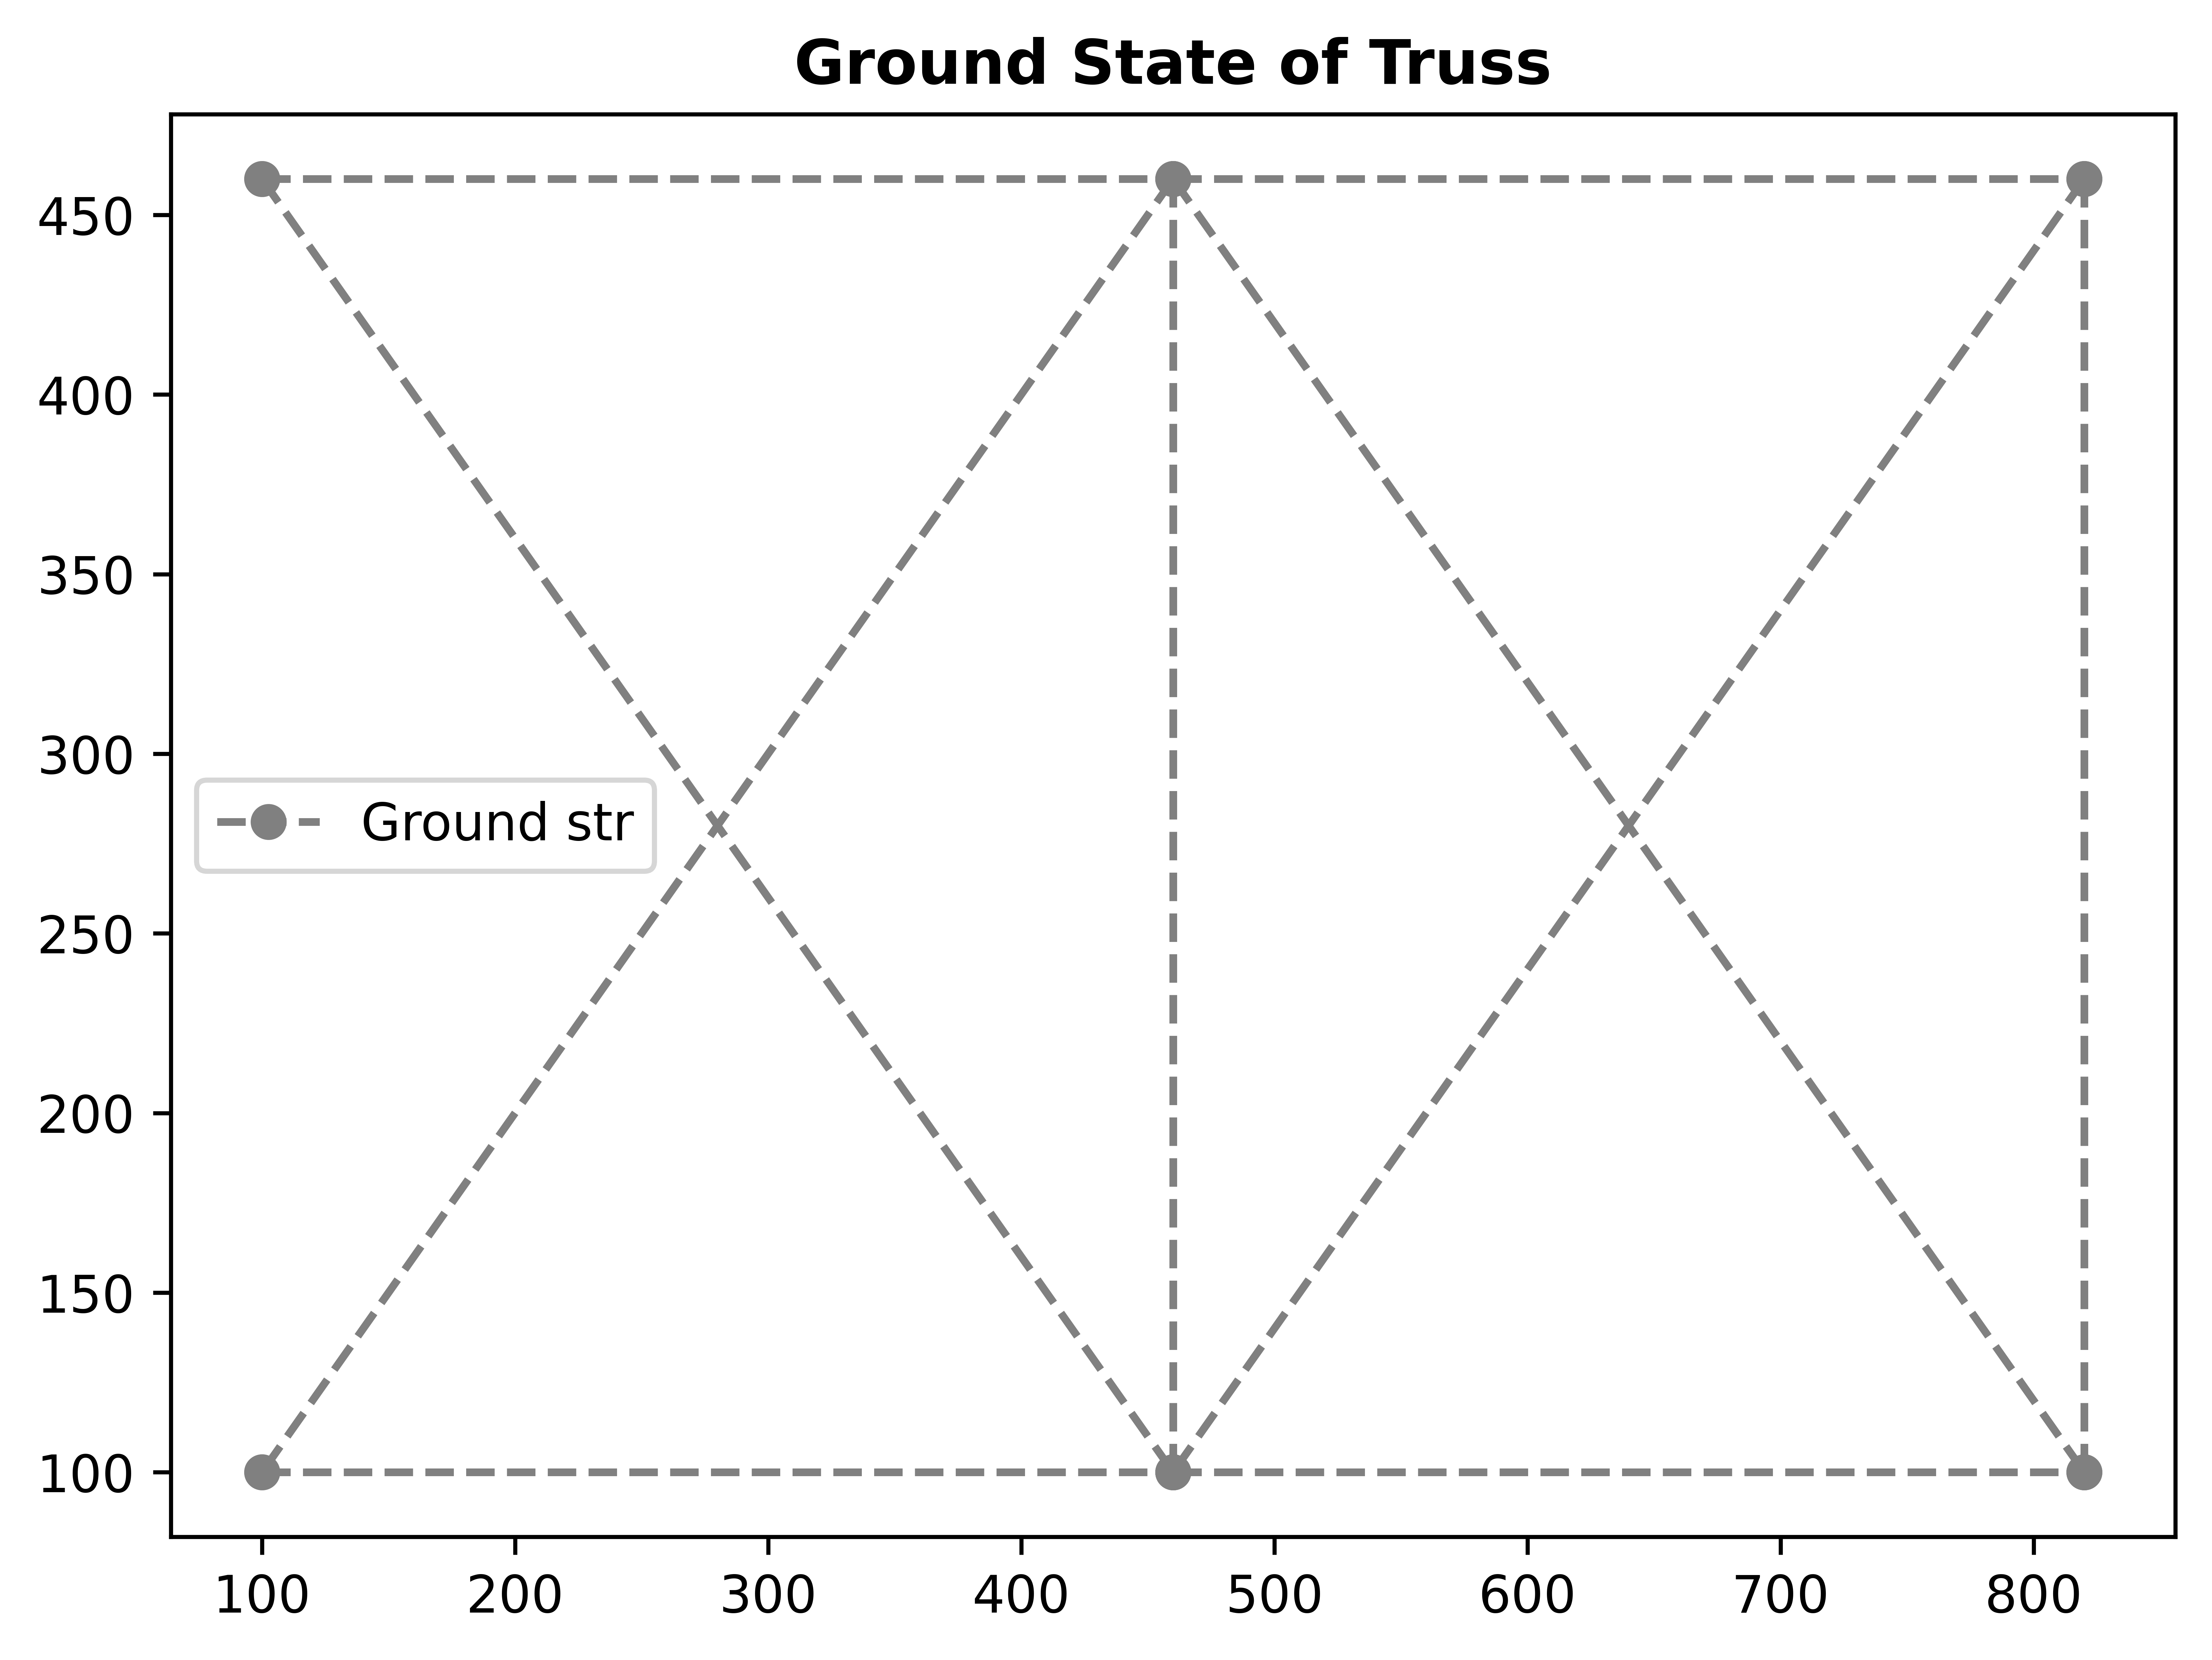

In [6]:
plt.figure(figsize=(7,5))
plt.title("Ground State of Truss", fontweight='bold')
for i in range(len(bars)):
    xi, xf = nodes[bars[i,0],0], nodes[bars[i, 1],0]
    yi, yf = nodes[bars[i, 0], 1], nodes[bars [i, 1],1]
    line, = plt.plot([xi, xf], [yi, yf], color='grey', linestyle='--', marker='o') 

line.set_label('Ground str')
plt.legend()
plt.show()

In [7]:
P = np.zeros_like(nodes) # 0 =nO LOAD # 1 == lOAD
P[4,1]= -100000
P[5,1]= -100000
print(P)

[[      0.       0.]
 [      0.       0.]
 [      0.       0.]
 [      0.       0.]
 [      0. -100000.]
 [      0. -100000.]]


In [8]:
Ur = [0,0,0,0]

In [9]:
# Defining the degrees of Freedoms
DOFCON = np.ones_like(nodes).astype(int)
DOFCON[0,:] = 0
DOFCON[3,:] = 0
print(DOFCON)

[[0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]]


In [10]:
# Truss Analysis
# Doing structural analysis of the truss for an constant area of 11.5 inch^2

In [11]:
@jax.jit
class basic(): 

    def min_area(area):
        computed_area =[]
        for i in area:
            if i<1:
                computed_area.append(1)
            else:
                computed_area.append(i)
        return np.array(computed_area)

    def area_gen(area):
        area_new = []
        for i in range(10):
            area_new.append(random.choice(area))
        return area_new

    def scaler(area):
        f=[]
        a = sum(area)
        for i in area:
            i=i*50
            f.append(i/a)
        return f

    def Plot(nodes, c, lt, area, lg):
        for i in range(len(bars)):
            xi, xf = nodes[bars[i,0],0], nodes[bars[i,1],0]
            yi, yf = nodes[bars[i,0],1], nodes[bars[i,1],1]
            a = np.round(basic.scaler(area), 3)
            line, = plt.plot([xi, xf], [yi,yf], color=c, linestyle=lt, linewidth=a[i],
                             label=f'\nArea : {area[i]} in^2\n', marker='o', solid_capstyle='round') #
        line, = plt.plot([xi, xf], [yi,yf], color=c, linestyle=lt, linewidth=0.001)
        line.set_label(lg)
        plt.legend(bbox_to_anchor=(1,1), loc="upper left", prop={'size':4})
    

    def check( STRESS, DEFLECTION):
        x=0
        y=0
        for i in STRESS:
            if np.abs(i) > s_lim:
                x +=1
                # print("Failed in Stress")
            else:
                pass
                #print("Pass in Stress")
        for i in range(6):
            ix = np.abs(DEFLECTION[i][0])
            iy = np.abs(DEFLECTION[i][1])
            if ix > d_lim:
                y+=1
                #print("Failed in Deflection along X")
            elif iy > d_lim:
                y +=1
                #print("Failed in Deflection along Y")
            else:
                pass
                #print("Pass in Deflection")
        if (x ==0) & (y==0):
            # print("Pass")
            return "Pass"
        else:
            # print(f'Failed in {x} ways for stress \n Failed in {y} ways for deflection ')
            return f'Failed in {x} ways for stress \n Failed in {y} ways for deflection '

@jax.jit
class Truss():
    # Truss Structural Analysis
    def TrussAnalysis(A, nodes, bars):
        NN = len(nodes) # number of nodes
        NE = len(bars) # number of deges
        # print(NE)

        DOF = 2 # defree of freedom
        NDOF = DOF*NN # total degree of freedom

        #structural analysis using direct stifness method

        # for bar no 3
        # takes info from node no 3 and substract it from infor of node no 2
        d = nodes[bars[:,1],:] - nodes[bars[:,0],:]
        
        L = np.sqrt((d**2).sum(axis=1)) #leangth of the bar
        # print(f"The Leangth is {L}")
        #computing the angle 
        angle = d.T/L
        # print(f"The angle is \n\n{angle}\n\n")
        #transformation vector {a ==Transformation vector}
        a = np.concatenate((-angle.T, angle.T), axis=1)
        # print(f"The transformation vector is \n\n{a}\n\n")

        #Global stifness matrix K
        K = np.zeros([NDOF,NDOF])
        
        
        for k in range(NE):
            aux = 2*bars[k,:]
            #gives you degree of freedom in each node
            index = np.r_[aux[0]:aux[0]+2, aux[1]:aux[1]+2]
            # print(f'a : {a.shape}, A: {A.shape}, L: {L.shape}')
            ES = np.dot(a[k][np.newaxis].T*E*A[k], a[k][np.newaxis])/L[k]
            # print(f"Stifness Matrix \n\n{ES}\n\n")
            K[np.ix_(index,index)] = K[np.ix_(index,index)] + ES

        freeDOF = DOFCON.flatten().nonzero()[0]
        supportDOF = (DOFCON.flatten()==0).nonzero()[0]

        Kff = K[np.ix_(freeDOF, freeDOF)]
        Kfr = K[np.ix_(freeDOF, supportDOF)]
        Krf = Kfr.T
        # print(f'{Kfr}, \n \n {Kff}, \n \n {Krf}')
        Krr = K[np.ix_(supportDOF, supportDOF)]
        
        Pf = P.flatten()[freeDOF]
        #Uf = np.linalg.solve(Kff, Pf) #.lstsq
        Uf = np.linalg.inv(Kff)@ Pf
        U  = DOFCON.astype(float).flatten()
        U[freeDOF] = Uf
        U[supportDOF] = Ur

        U = U.reshape(NN, DOF) #displacement of the truss members
        u = np.concatenate((U[bars[:,0]], U[bars[:,1]]), axis=1)
        # print(E)
        # print(A)
        N = E*A[:]/L[:]*(a[:]*u[:]).sum(axis=1)
        R = (Krf[:]*Uf).sum(axis=1) + (Krr[:]*Ur).sum(axis=1) #Reaction Force
        R = R.reshape(2,DOF)

        # Stress
        S = N/A

        #weight of str
        Volume = (1*A*L).sum() #for mass replace 1 by p

        #check
        c = basic.check(S, U)

        return S, Volume, U, c, R

basic = jax.jit(basic)
Truss = jax.jit(Truss)

In [12]:
x = np.array([20 for i in range(10)]).astype(float)
x

array([20., 20., 20., 20., 20., 20., 20., 20., 20., 20.])

In [13]:
Truss.TrussAnalysis(x, nodes, bars)

(array([  9768.24934844,   2006.23161277, -10231.75065156,  -2993.76838723,
          1774.48096122,   2006.23161277,   7398.81272639,  -6743.32289734,
          4233.82785582,  -2837.23995605]),
 83929.35059634515,
 array([[ 0.        ,  0.        ],
        [ 0.35165698, -0.83717623],
        [ 0.42388131, -1.89756315],
        [ 0.        ,  0.        ],
        [-0.36834302, -0.90105754],
        [-0.47611869, -1.96978749]]),
 'Pass',
 array([[-300000.        ,  104635.01303119],
        [ 300000.        ,   95364.98696881]]))

In [14]:


# members = bars
# # Define the ACO parameters
# num_ants = 20
# num_iterations = 100
# alpha = 1
# beta = 2
# rho = 0.1

# # Define the function to calculate the volume of the truss
# def truss_volume(nodes, members, best_path):
#     if len(best_path)==10:
#         ans = Truss.TrussAnalysis(best_path, nodes, bars)
#     else:
#         best_path.append([1]*(10-len(best_path)))
#     ans = Truss.TrussAnalysis(x, nodes, bars)
#     if ans[3] == "Pass":
#         return ans[1]
#     else:
#         return 9999999

# # Initialize the pheromone matrix
# pheromone = np.ones((len(nodes), len(nodes)))

# # Run the ACO algorithm
# best_volume = float('inf')
# best_path = None
# for i in range(num_iterations):
#     paths = []
#     volumes = []
#     for j in range(num_ants):
#         path = []
#         current_node = random.randint(0, len(nodes) - 1)
#         while len(path) < len(members):
#             path.append(current_node)
#             next_node = None
#             next_node_prob = 0
#             for k in range(len(nodes)):
#                 if k not in path:
#                     prob = (pheromone[current_node][k] ** alpha) * ((1 / truss_volume(nodes, members, [current_node, k])) ** beta)
#                     if prob > next_node_prob:
#                         next_node = k
#                         next_node_prob = prob
#             current_node = next_node
#         paths.append(path)
#         volumes.append(truss_volume(nodes, members, path))
#     for j in range(len(nodes)):
#         for k in range(len(nodes)):
#             pheromone[j][k] *= (1 - rho)
#     for j in range(len(paths)):
#         for k in range(len(paths[j]) - 1):
#             n1, n2 = paths[j][k], paths[j][k + 1]
#             pheromone[n1][n2] += 1 / volumes[j]
#             #pheromone[n2][n1] = pheromone[n1][n2]
#     if min(volumes) < best_volume:
#         best_volume = min(volumes)
#         best_path = paths[volumes.index(best_volume)]

# # Print the results
# print("Best volume:", best_volume)
# print("Best path:", best_path)



In [15]:
# import random

# class Ant:
#     def __init__(self, graph):
#         self.graph = graph
#         self.path = []
#         self.total_cost = 0

#     def move(self):
#         current_node = random.choice(list(self.graph.keys()))
#         self.path.append(current_node)
#         while len(self.path) < len(self.graph):
#             next_node = self.select_next_node(current_node)
#             self.path.append(next_node)
#             self.total_cost += self.graph[current_node][next_node]
#             current_node = next_node

#     def select_next_node(self, current_node):
#         next_node = None
#         max_prob = 0
#         for node in self.graph:
#             if node not in self.path:
#                 prob = self.transition_probability(current_node, node)
#                 if prob > max_prob:
#                     max_prob = prob
#                     next_node = node
#         return next_node

#     def transition_probability(self, current_node, next_node):
#         tau = self.graph[current_node][next_node]
#         sum_tau = sum([self.graph[current_node][node] for node in self.graph if node not in self.path])
#         return tau / sum_tau

# class ACO:
#     def __init__(self, graph, num_ants, num_iterations):
#         self.graph = graph
#         self.num_ants = num_ants
#         self.num_iterations = num_iterations
#         self.ants = []

#     def solve(self):
#         best_cost = float('inf')
#         best_path = None
#         for i in range(self.num_iterations):
#             self.ants = [Ant(self.graph) for i in range(self.num_ants)]
#             for ant in self.ants:
#                 ant.move()
#                 if ant.total_cost < best_cost:
#                     best_cost = ant.total_cost
#                     best_path = ant.path
#         return best_path, best_cost


In [26]:
import random
import math




class Ant:

    def __init__(self, lower_bound, upper_bound):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.x = self.data_gen()
        self.y = Truss.TrussAnalysis(self.x, nodes, bars)[1] #(2*self.x - 5)**2 #(2*x-5)**2
        self.path = [self.x]
        self.total_cost = self.y


    def data_gen(self):
        data = []
        for i in range(10):
            data.append(random.uniform(self.lower_bound, self.upper_bound))
        return np.array(data)
    
    def move(self):
        next_x = np.array([random.uniform(self.lower_bound, self.upper_bound)]*10)
        next_y = Truss.TrussAnalysis(next_x, nodes, bars)[1]# (2*next_x - 5)**2 #(2*(next_x**2) + 5)**2
        delta_y = next_y - self.y

        # if math.exp(-delta_y+1e-7) > random.random():
        #     self.x = next_x
        #     self.y = next_y
        #     self.path.append(self.x)
        #     self.total_cost = self.y

        # if delta_y < 0:
        #     return math.exp(delta_y)
        # else:
        #     return 0

        if np.exp(-delta_y) > random.random():
            self.x = next_x
            self.y = next_y
            self.path.append(self.x)
            self.total_cost = self.y

class ACO:
    def __init__(self, num_ants, num_iterations, lower_bound, upper_bound):
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.ants = []

    def solve(self):
        
        best_cost = float('inf')
        best_path = None
        for i in range(self.num_iterations):
            self.ants = [Ant(self.lower_bound, self.upper_bound) for i in range(self.num_ants)]
            for ant in self.ants:
                ant.move()
                if (ant.total_cost < best_cost) and Truss.TrussAnalysis(ant.x, nodes, bars)[3] =="Pass":
                    best_cost = ant.total_cost
                    best_path = ant.path
        return best_path, best_cost

aco = ACO(num_ants=10, num_iterations=100, lower_bound=10, upper_bound=100)
best_path, best_cost = aco.solve()
print("Best path:", best_path)
print("Best cost:", best_cost)


/tmp/ipykernel_12973/583615111.py:40: RuntimeWarning: overflow encountered in exp
  if np.exp(-delta_y) > random.random():


Best path: [array([11.95450487, 89.7158538 , 35.89479303, 41.09706309, 90.97881216,
       30.38046695, 22.28141571, 11.59928697, 87.28440178, 56.86694859]), array([19.71926211, 19.71926211, 19.71926211, 19.71926211, 19.71926211,
       19.71926211, 19.71926211, 19.71926211, 19.71926211, 19.71926211])]
Best cost: 82751.24315560755


In [22]:
Truss.TrussAnalysis(best_path[0], nodes, bars)

(array([  9901.12750912,   2033.52251794, -10370.93385201,  -3034.49282234,
          1798.6193465 ,   2033.52251794,   7499.45927945,  -6835.05277764,
          4291.42090428,  -2875.83512426]),
 82802.97607746311,
 array([[ 0.        ,  0.        ],
        [ 0.35644059, -0.84856439],
        [ 0.4296474 , -1.92337584],
        [ 0.        ,  0.        ],
        [-0.37335362, -0.91331469],
        [-0.48259536, -1.99658265]]),
 'Pass',
 array([[-300000.        ,  104635.01303119],
        [ 300000.        ,   95364.98696881]]))

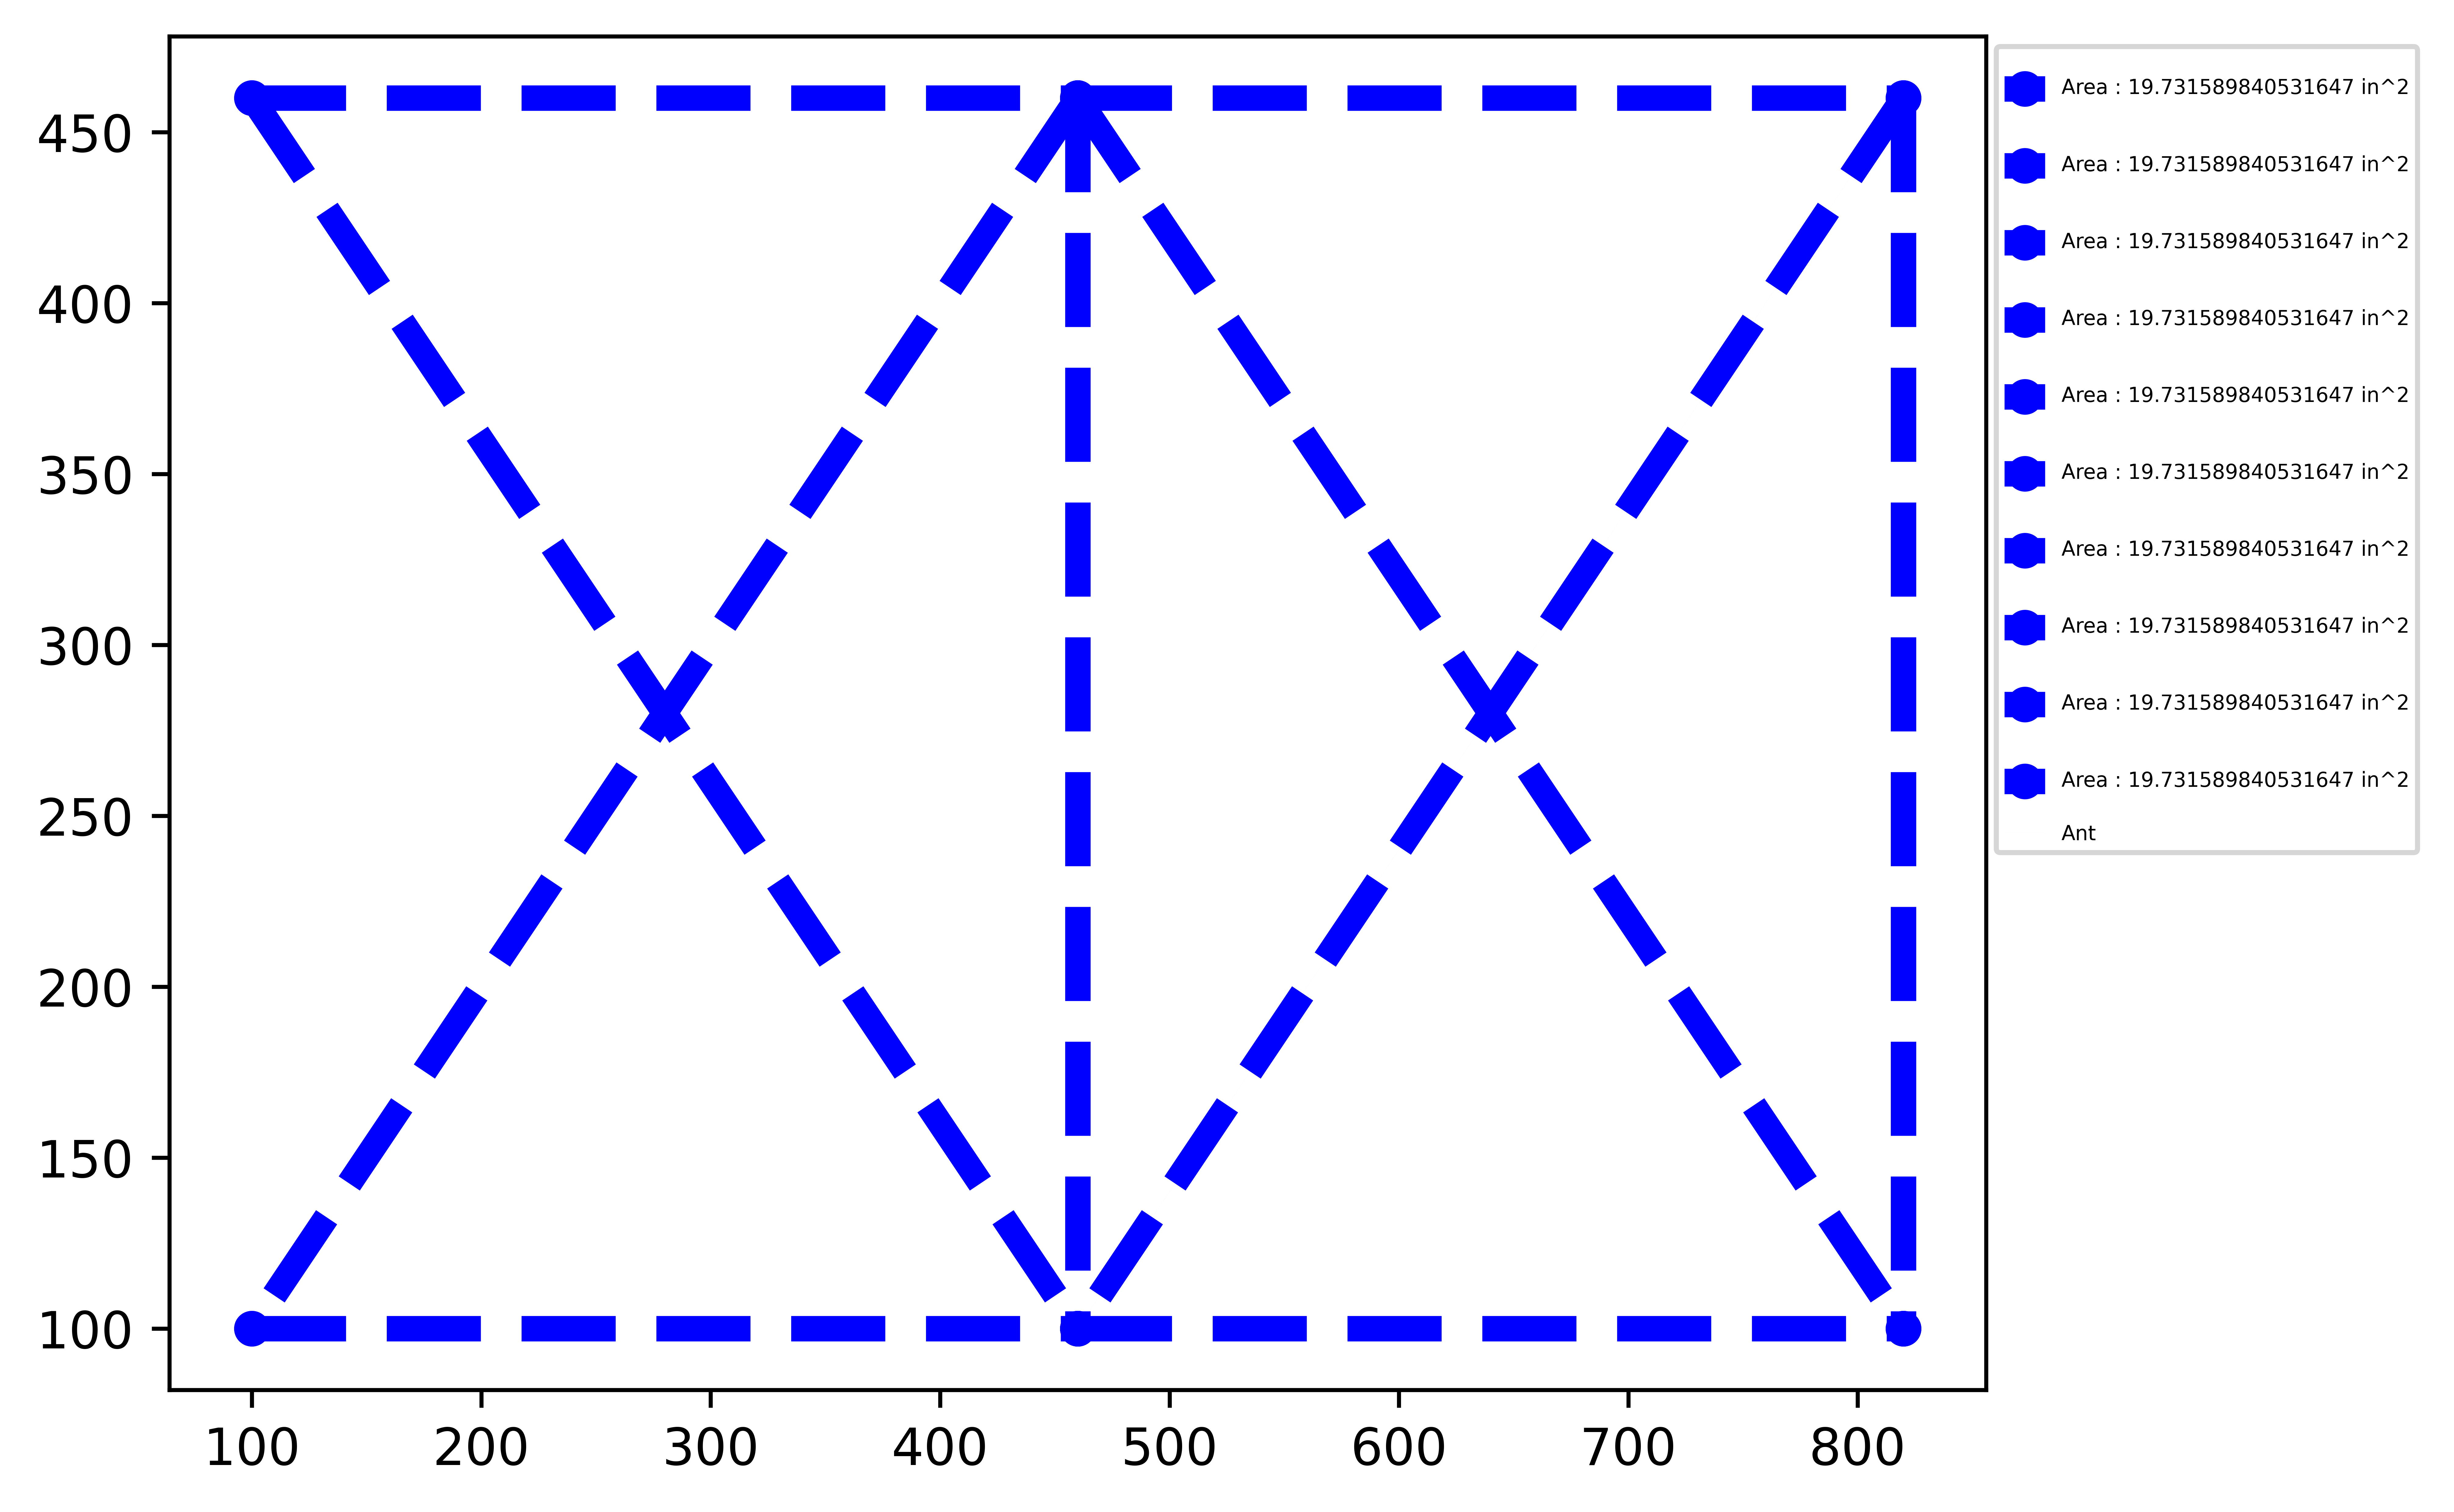

In [23]:
basic.Plot(nodes, "b", "--", best_path[0], "Ant")